<h1>Chord Representation and Indexing with Chromagrams</h1>
<br>
In this Notebook we are going to explore a different approach on the preprocessing of chord annotations and spectrogramms.<br>
We used one hot encodings for every timestep of the spectrogram, and saw the enormous amount of memory that was needed.<br>
<br>

In [1]:
import sys
# do this only once
sys.path.append('./src/audio-processing/')
sys.path.append('./src/data-processing/')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#python input/output and regex
import re
import os
from pathlib import Path

#chord info
import pychord as pc

#signal processing libraries
from scipy.io import wavfile
from scipy import signal

#sklearn for normalization
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#tensorflow
import tensorflow as tf
from tensorflow import keras

#librosa
import librosa
import librosa.display

#import custom modules
import filters
import spectrograms
import audiofiles
from annotation_processing import chords_to_onehot

<h2>Chord Representations</h2><br>
<b>Idea: </b> Instead of having one hot vectors of size N, where N is the number of unique chords in the dataset, we will connect the notes with the chords. Meaning, a <b>G</b> chord is comprised of a G, B and a D. <b>G7</b> is comprised of G,B,D,F. <b>C#</b> is comprised of C#,E#(F),G#. Etc.<br>
<br><b>Explore the use of Chromagrams instead of spectrograms</b><br>
https://musicinformationretrieval.com/chroma.html<br>
<br>
So, let's build a tool, that will <u>map</u> <b>Chords to Notes</b> and <b>Notes to Chords</b><br>

In [3]:
Semitones = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

In [4]:
def Chord_to_Notes(chord):
    if chord == 'N':
        return []
    if chord in Semitones:
        c = pc.Chord(chord)
        return c.components()
    #to get here means, this chord is augmented/diminished or inversed
    #I need to build smthing here for them
    return Semitones

In [5]:
def Notes_to_Chord(Notes):
    Chords = []
    for Note_Set in Notes:
        Chords.append(pc.note_to_chord(Note_Set))
    return Chords

In [6]:
def Extend_Annotations(filename):
    chordlab = pd.read_csv(filename, names=['Starts', 'Ends', 'Chord'], sep=' ', header=None)
    #init list
    notes = []
    for counter in range(len(Semitones)):
        notes.append([])
    #loop over annotation chords
    for Annotation in chordlab['Chord']:
        Notes_exist = Chord_to_Notes(Annotation)
        counter = 0
        for note in Semitones:
            if note not in Notes_exist:
                notes[counter].append(0)
            else:
                notes[counter].append(1)
            counter += 1 
    #append note lists on pandas dataframe
    counter = 0
    for note in Semitones:
        chordlab[note] = notes[counter]
        counter += 1
        
    return chordlab

After we built these tools, we will create a dataset, where the encodings of each chord won't be of size (407,1) but of (#NumberOfNotes,1)

In [7]:
### get all chordlab files
Chordlab = {'The Beatles': {}}
for filename in Path('Big-Dataset/The Beatles').glob('**/scratch/**/*.lab'):
    
    path, track = os.path.split(filename)
    path, album = os.path.split(path)
    track_no = re.search('([0-9].)_-_',track).group(1)
    
    if (album not in Chordlab['The Beatles']): 
        Chordlab['The Beatles'][album] = {}
        
    Chordlab['The Beatles'][album][track_no] = Extend_Annotations(filename)

In [8]:
#Display chordlab format
display (Chordlab['The Beatles'][album][track_no])

,Starts,Ends,Chord,C,C#,D,D#,E,F,F#,G,G#,A,A#,B
0,0.000000,0.511897,N,0,0,0,0,0,0,0,0,0,0,0,0
1,0.511897,3.376166,D,0,0,1,0,0,0,1,0,0,1,0,0
2,3.376166,6.178742,E:min,1,1,1,1,1,1,1,1,1,1,1,1
3,6.178742,7.585845,B:min,1,1,1,1,1,1,1,1,1,1,1,1
4,7.585845,9.027834,A,0,1,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,138.388235,139.562757,E:min,1,1,1,1,1,1,1,1,1,1,1,1
82,139.562757,141.109407,A,0,1,0,0,1,0,0,0,0,1,0,0
83,141.109407,142.342076,E:min,1,1,1,1,1,1,1,1,1,1,1,1
84,142.342076,144.391973,A,0,1,0,0,1,0,0,0,0,1,0,0


<h2>Chromagrams</h2>
<br>
1. Constructing chromagram from raw audio:<br>

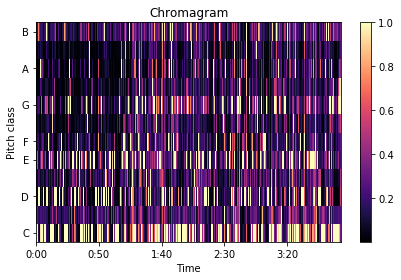

In [13]:
track, sr = librosa.load('Audiofiles/The Beatles/12_-_Let_It_Be/wav/06.Let It Be (Remastered 2009).wav')
track_time = librosa.get_duration(y=track, sr=sr)

hop_length = 512
n_fft = int(track_time // (hop_length / sr))

chroma = librosa.feature.chroma_stft(track, sr=sr, n_fft=n_fft, hop_length=hop_length)

librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()
plt.show()

In [14]:
chroma.shape

(12, 10469)

## Estimation with Chromagrams

<h3>Loading Datasets</h3>

In [9]:
### get all chordlab files
Chordlab = {'The Beatles': {}}
for filename in Path('Big-Dataset/The Beatles').glob('**/scratch/**/*.lab'):
    
    path, track = os.path.split(filename)
    path, album = os.path.split(path)
    track_no = re.search('([0-9].)_-_',track).group(1)
    
    if (album not in Chordlab['The Beatles']): 
        Chordlab['The Beatles'][album] = {}
        
    Chordlab['The Beatles'][album][track_no] = pd.read_csv(filename, names=['Starts', 'Ends', 'Chord'], sep=' ', header=None)

<h3>Chord Vocab</h3>

In [10]:
### Load all chords in a dictionary
Chords = []
for album in Chordlab['The Beatles'].keys():
    for track_no in Chordlab['The Beatles'][album].keys():
        for index, row in Chordlab['The Beatles'][album][track_no].iterrows():
            if row['Chord'] not in Chords: Chords.append(row['Chord'])
                
### How many chords do we have in our dataset?
print ("Unique Chords in our Dataset: ",len(Chords))

Unique Chords in our Dataset:  407


<h3>Create Chromagrams</h3>

In [11]:
hop_length = 512
Semitones = 12

### get all audio files and create chromagram for each track
Chromagrams, Timestamps = spectrograms.create_chromagrams(hop_length, 'Audiofiles/The Beatles')

<h3>Preprocessings</h3>

<h4>One hot encodings with sklearn</h4>

In [12]:
encoder = OneHotEncoder()
encoder.fit(np.array(pd.Series(Chords)).reshape(-1,1))

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

<h4>Indexing chroma with timesteps</h4>

In [13]:
chords2vec = chords_to_onehot(encoder, Timestamps, Chordlab, Chords)

In [25]:
### STORE
import pickle

with open('chroma_indexed.pickle', 'wb') as handle:
    pickle.dump(chords2vec, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
### LOAD
import pickle

with open('chroma_indexed.pickle', 'rb') as handle:
    chords2vec = pickle.load(handle)

<h4>Constructing numpy arrays</h4>

In [14]:
chunk_size = 500

In [15]:
x_train = np.zeros((1,chunk_size,Semitones)) #num of frequencies
y_train = np.zeros((1,chunk_size,len(Chords)))
x_test = np.zeros((1,chunk_size,Semitones)) #num of frequencies
y_test = np.zeros((1,chunk_size,len(Chords)))

#test track
test_track_no = '01'
album_test_track = '09_-_Magical_Mystery_Tour'

for album in chords2vec.keys():
    for track_no in chords2vec[album].keys():
        timestep = 0
        # size of the current track
        chunks = chords2vec[album][track_no].T.shape[0]
        # track frequencies
        spectrogram = Chromagrams['The Beatles'][album][track_no]
        # track annotations
        annotations = chords2vec[album][track_no].T
        # slice and stack train-test data
        if track_no != test_track_no or album != album_test_track:
            # train tracks
            while timestep < chunks :
                if (chunks - timestep) > chunk_size:
                    batch_x = np.resize(spectrogram[timestep:timestep+chunk_size,:], (1, chunk_size, Semitones)) #num of frequencies
                    x_train = np.append(x_train, batch_x, axis = 0)
                    batch_y = np.resize(annotations[timestep:timestep+chunk_size,:], (1, chunk_size, len(Chords)))
                    y_train = np.append(y_train, batch_y, axis = 0)
                else:
                    batch_x = spectrogram[timestep:,:]
                    batch_y = annotations[timestep:,:]
                    for step in range (0, chunk_size + timestep - chunks):
                        batch_x = np.vstack((batch_x, np.zeros((1,Semitones))))
                        batch_y = np.vstack((batch_y, encoder.transform([['N']]).toarray()[0]))
                    x_train = np.append(x_train, np.array([batch_x]), axis = 0)
                    y_train = np.append(y_train, np.array([batch_y]), axis = 0)
                timestep += chunk_size
        else:
            # test tracks
            while timestep < chunks :
                if (chunks - timestep) > chunk_size:
                    batch_x = np.resize(spectrogram[timestep:timestep+chunk_size,:], (1, chunk_size, Semitones)) #num of frequencies
                    x_test = np.append(x_test, batch_x, axis = 0)
                    batch_y = np.resize(annotations[timestep:timestep+chunk_size,:], (1, chunk_size, len(Chords)))
                    y_test = np.append(y_test, batch_y, axis = 0)
                else:
                    batch_x = spectrogram[timestep:,:]
                    batch_y = annotations[timestep:,:]
                    for step in range (0, chunk_size + timestep - chunks):
                        batch_x = np.vstack((batch_x, np.zeros((1,Semitones))))
                        batch_y = np.vstack((batch_y, encoder.transform([['N']]).toarray()[0]))
                    x_test = np.append(x_test, np.array([batch_x]), axis = 0)
                    y_test = np.append(y_test, np.array([batch_y]), axis = 0)
                # augment timesteps
                timestep += chunk_size

print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(2591, 500, 12) (2591, 500, 407) (16, 500, 12) (16, 500, 407)


Delete the first row from every array because of the append, which left it all zeros.

In [16]:
x_train = np.delete(x_train,0,0)
y_train = np.delete(y_train,0,0)
x_test = np.delete(x_test,0,0)
y_test = np.delete(y_test,0,0)

In [17]:
print(x_train.shape)
print(y_train.shape)
print (x_test.shape)
print (y_test.shape)

(2590, 500, 12)
(2590, 500, 407)
(15, 500, 12)
(15, 500, 407)


In [18]:
x_train2 = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
y_train2 = np.reshape(y_train,(y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))
x_test2 = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
y_test2 = np.reshape(y_test,(y_test.shape[0], y_test.shape[1], y_test.shape[2], 1))

## Neural Network

In [19]:
from tensorflow.keras.layers import Input, TimeDistributed, Embedding, LSTM, Bidirectional, Dropout, Dense, GRU, concatenate, Conv1D, Conv2D, Flatten,MaxPooling1D, LocallyConnected1D, Activation, GaussianNoise, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal, RandomUniform

#### BLSTM_2Layer

In [81]:
def BLSTM_2Layer(chords_num, features, timesteps, batch_size):
    
    main_input = Input(shape=(timesteps,features), name='main_input')
    
    #BLSTM
    x = Bidirectional(LSTM(units = 30, 
                           kernel_initializer = 'glorot_uniform',
                           bias_initializer = RandomNormal(),
                           recurrent_activation='sigmoid',
                           recurrent_regularizer='l2',
                           return_sequences=True))(main_input)
    x = Dropout(0.1)(x)
    #BLSTM
    x = Bidirectional(LSTM(units = 30,
                           kernel_initializer = 'glorot_uniform',
                           bias_initializer = RandomNormal(),
                           recurrent_activation='sigmoid',
                           recurrent_regularizer='l2',
                           return_sequences=True))(x)
    
    x = Dropout(0.1)(x)
    #Dense for classification
    main_output = TimeDistributed(Dense(chords_num, activation='softmax'))(x)
    #model
    model = Model(inputs=[main_input], outputs=[main_output])

    return model

#### Summary

In [82]:
chroma_model = BLSTM_2Layer(len(Chords), Semitones, chunk_size, batch_size)

chroma_model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

chroma_model.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 500, 12)]         0         
_________________________________________________________________
bidirectional_38 (Bidirectio (None, 500, 60)           10320     
_________________________________________________________________
dropout_56 (Dropout)         (None, 500, 60)           0         
_________________________________________________________________
bidirectional_39 (Bidirectio (None, 500, 60)           21840     
_________________________________________________________________
dropout_57 (Dropout)         (None, 500, 60)           0         
_________________________________________________________________
time_distributed_74 (TimeDis (None, 500, 407)          24827     
Total params: 56,987
Trainable params: 56,987
Non-trainable params: 0
______________________________________________________

**Fit**

In [83]:
epochs = 20
batch_size = 32

# train
callback_history = chroma_model.fit(x_train, y_train, epochs=epochs,
          validation_data=(x_test, y_test), batch_size=batch_size, verbose=1)

Train on 2590 samples, validate on 15 samples
Epoch 1/20
2590/2590 [==============================] - 23s 9ms/sample - loss: 5.2396 - accuracy: 0.0933 - val_loss: 3.7298 - val_accuracy: 0.1616
Epoch 2/20
2590/2590 [==============================] - 19s 7ms/sample - loss: 3.9882 - accuracy: 0.1494 - val_loss: 3.2197 - val_accuracy: 0.4323
Epoch 3/20
2590/2590 [==============================] - 19s 7ms/sample - loss: 3.6139 - accuracy: 0.2631 - val_loss: 2.8435 - val_accuracy: 0.4761
Epoch 4/20
2590/2590 [==============================] - 19s 7ms/sample - loss: 3.3171 - accuracy: 0.3135 - val_loss: 2.5896 - val_accuracy: 0.5356
Epoch 5/20
2590/2590 [==============================] - 19s 7ms/sample - loss: 3.0773 - accuracy: 0.3680 - val_loss: 2.3940 - val_accuracy: 0.5420
Epoch 6/20
2590/2590 [==============================] - 18s 7ms/sample - loss: 2.8934 - accuracy: 0.3958 - val_loss: 2.3185 - val_accuracy: 0.5339
Epoch 7/20
2590/2590 [==============================] - 19s 7ms/sample -

In [84]:
# evaluate on test set
loss, accuracy = chroma_model.evaluate([x_test], y_test, verbose=0)
print("Loss: \t\t% 3.3f \nAccuracy: \t% 3.2f %%" %(loss, 100*accuracy))

Loss: 		 1.988 
Accuracy: 	 54.48 %


**Predictions -> Chords**

In [85]:
predictions = chroma_model.predict(x_test, batch_size=batch_size, use_multiprocessing=True)

In [86]:
estimated_chord_list = []
real_chord_list = Chordlab['The Beatles'][album_test_track][test_track_no]

for batch_chords in predictions:
    for chord in batch_chords:
        estimated_chord_list.append(encoder.inverse_transform([chord]).reshape(1,)[0])
        
df_predictions = pd.DataFrame({'Estimated Chords' : estimated_chord_list})
display(df_predictions)

,Estimated Chords
0,N
1,N
2,N
3,N
4,N
...,...
7495,N
7496,N
7497,N
7498,N


### Plot Efficiency of model

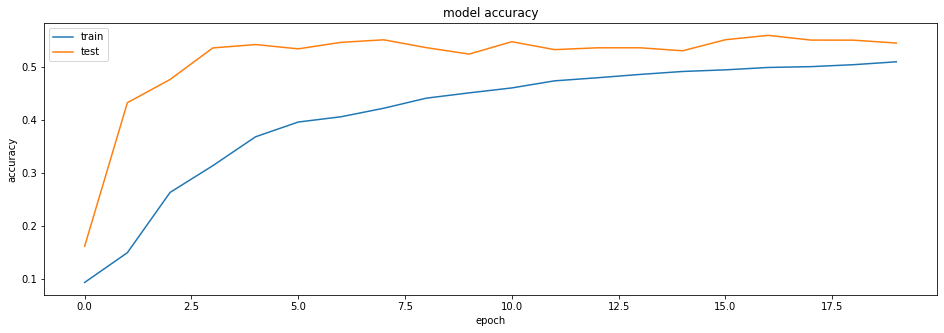

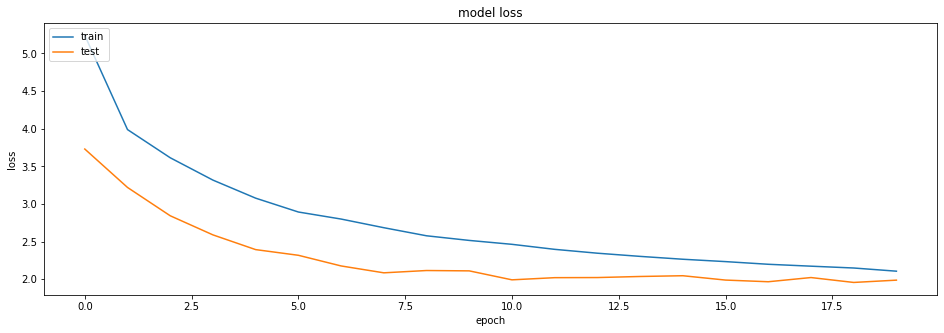

In [87]:
plt.figure(figsize=(16,5))
# summarize history for accuracy
plt.plot(callback_history.history['accuracy'])
plt.plot(callback_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.figure(figsize=(16,5))
# summarize history for loss
plt.plot(callback_history.history['loss'])
plt.plot(callback_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Conv1D_BLSTM_2Layer

In [94]:
def Conv1D_BLSTM_2Layer(chords_num, features, timesteps, batch_size):
    
    main_input = Input(shape=(timesteps,features,1), name='main_input')
    
    #Convolutional Stack 1
    c =  TimeDistributed(Conv1D(filters=32, 
               kernel_size=3, 
               padding='same'), input_shape=(timesteps, features, 1))(main_input)
    
    c =  TimeDistributed(Conv1D(filters=32, 
               kernel_size=3, 
               padding='same'), input_shape=(timesteps, features, 1))(c)
    c = Dropout(0.25)(c)
    
    
    #Convolutional Stack 2
    c =  TimeDistributed(Conv1D(filters=64, 
               kernel_size=3, 
               padding='same'), input_shape=(timesteps, features, 1))(c)
    
    c =  TimeDistributed(Conv1D(filters=64, 
               kernel_size=3, 
               padding='same'), input_shape=(timesteps, features, 1))(c)
    c = Dropout(0.25)(c)
    
    #Convolutional Stack 2
    c =  TimeDistributed(Conv1D(filters=128, 
               kernel_size=3, 
               padding='same'), input_shape=(timesteps, features, 1))(c)
    
    c =  TimeDistributed(Conv1D(filters=128, 
               kernel_size=3, 
               padding='same'), input_shape=(timesteps, features, 1))(c)
    c = Dropout(0.25)(c)
    
    x = TimeDistributed(Flatten())(c)
    x = BatchNormalization()(x)

    #BLSTM on the concatanted output
    x = Bidirectional(LSTM(units = 30,
                           kernel_initializer = 'glorot_uniform',
                           bias_initializer = RandomNormal(),
                           recurrent_activation='sigmoid',
                           recurrent_regularizer='l2',
                           return_sequences=True))(x)
    #BLSTM on the concatanted output
    x = Bidirectional(LSTM(units = 30,
                           kernel_initializer = 'glorot_uniform',
                           bias_initializer = RandomNormal(),
                           recurrent_activation='sigmoid',
                           recurrent_regularizer='l2',
                           return_sequences=True))(x)
    #Dense for classification
    main_output = TimeDistributed(Dense(chords_num, activation='softmax'))(x)
    
    #model
    model = Model(inputs=[main_input], outputs=[main_output])

    return model

#### Summary

In [95]:
chroma_model = Conv1D_BLSTM_2Layer(len(Chords), Semitones, chunk_size, batch_size)

chroma_model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

chroma_model.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 500, 12, 1)]      0         
_________________________________________________________________
time_distributed_81 (TimeDis (None, 500, 12, 32)       128       
_________________________________________________________________
time_distributed_82 (TimeDis (None, 500, 12, 32)       3104      
_________________________________________________________________
dropout_60 (Dropout)         (None, 500, 12, 32)       0         
_________________________________________________________________
time_distributed_83 (TimeDis (None, 500, 12, 64)       6208      
_________________________________________________________________
time_distributed_84 (TimeDis (None, 500, 12, 64)       12352     
_________________________________________________________________
dropout_61 (Dropout)         (None, 500, 12, 64)       0  

#### Fit

In [96]:
epochs = 20
batch_size = 32

# train
callback_history_2 = chroma_model.fit(x_train2, y_train, epochs=epochs,
          validation_data=(x_test2, y_test), batch_size=batch_size, verbose=1)

Train on 2590 samples, validate on 15 samples
Epoch 1/20
2590/2590 [==============================] - 90s 35ms/sample - loss: 4.8936 - accuracy: 0.3102 - val_loss: 2.9075 - val_accuracy: 0.4961
Epoch 2/20
2590/2590 [==============================] - 85s 33ms/sample - loss: 3.0781 - accuracy: 0.4199 - val_loss: 2.3378 - val_accuracy: 0.5147
Epoch 3/20
2590/2590 [==============================] - 83s 32ms/sample - loss: 2.6598 - accuracy: 0.4545 - val_loss: 2.1733 - val_accuracy: 0.5232
Epoch 4/20
2590/2590 [==============================] - 83s 32ms/sample - loss: 2.4578 - accuracy: 0.4786 - val_loss: 2.0653 - val_accuracy: 0.5573
Epoch 5/20
2590/2590 [==============================] - 83s 32ms/sample - loss: 2.3472 - accuracy: 0.4928 - val_loss: 1.9467 - val_accuracy: 0.5675
Epoch 6/20
2590/2590 [==============================] - 84s 32ms/sample - loss: 2.2489 - accuracy: 0.5073 - val_loss: 2.0006 - val_accuracy: 0.5635
Epoch 7/20
2590/2590 [==============================] - 87s 33ms/s

In [97]:
# evaluate on test set
loss, accuracy = chroma_model.evaluate([x_test2], y_test, verbose=0)
print("Loss: \t\t% 3.3f \nAccuracy: \t% 3.2f %%" %(loss, 100*accuracy))

Loss: 		 1.970 
Accuracy: 	 59.77 %


### Plot Efficiency of model

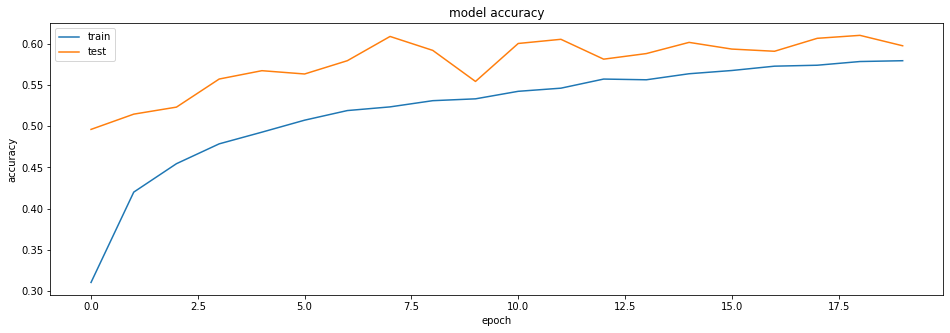

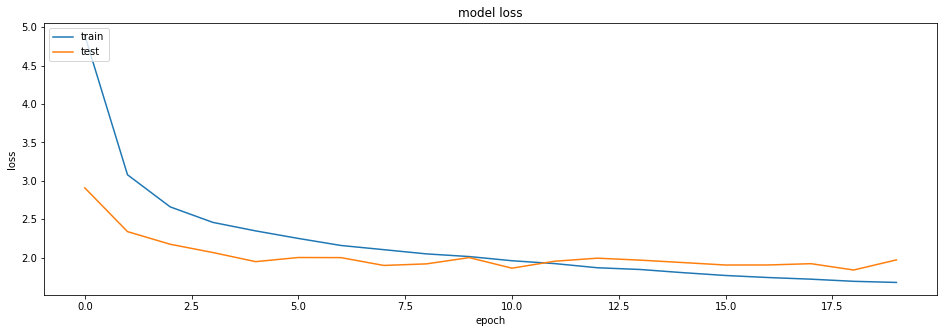

In [98]:
plt.figure(figsize=(16,5))
# summarize history for accuracy
plt.plot(callback_history_2.history['accuracy'])
plt.plot(callback_history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.figure(figsize=(16,5))
# summarize history for loss
plt.plot(callback_history_2.history['loss'])
plt.plot(callback_history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()